# Climate U-Net Full Evaluation

This notebook provides comprehensive evaluation of the trained Climate U-Net model following WeatherBench 2 standards.

## Standard Weather Prediction Metrics

### Primary Metrics (WeatherBench 2)
1. **RMSE (Root Mean Squared Error)** - Primary metric, latitude-weighted
2. **ACC (Anomaly Correlation Coefficient)** - Skill vs climatology, 0.6 threshold for "useful" forecast
3. **Bias** - Systematic over/under prediction

### Variables of Interest
Our 6-channel model predicts:
- `z500` - Geopotential at 500hPa (key for synoptic patterns)
- `t850` - Temperature at 850hPa (lower troposphere)
- `u850`, `v850` - Wind components at 850hPa
- `t2m` - 2-meter temperature (surface)
- `msl` - Mean sea level pressure

### Benchmark Context
| Model | Z500 RMSE (3d) | T850 RMSE (3d) | Notes |
|-------|----------------|----------------|-------|
| ECMWF IFS | 154 m²/s² | 1.36 K | Operational NWP |
| GraphCast | ~140 m²/s² | ~1.2 K | State-of-art ML |
| Pangu-Weather | ~145 m²/s² | ~1.25 K | State-of-art ML |
| ResNet baseline | 268 m²/s² | 1.65 K | Simple CNN |

**Note**: Our model predicts 6h ahead (not 3 days), so direct comparison isn't possible, but we can establish baselines.

In [1]:
import sys
sys.path.insert(0, '../inference')

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from climate_unet import ClimateUNet, load_fortran_weights

# Configuration
CLIMATE_DATA_DIR = Path('../../v28d_streaming/datasets/climate/')
WEIGHTS_DIR = CLIMATE_DATA_DIR / 'saved_models/climate_unet/epoch_0021'  # Best checkpoint
STREAMING_DIR = CLIMATE_DATA_DIR / 'climate_data_streaming'

# Dataset parameters (from climate_config)
N_CHANNELS = 6
LAT = 240
LON = 121
FEATURES = N_CHANNELS * LAT * LON  # 174,240
TRAIN_SAMPLES = 55519
TEST_SAMPLES = 5843  # 2017-2020 data

CHANNEL_NAMES = ['z500', 't850', 'u850', 'v850', 't2m', 'msl']
CHANNEL_UNITS = ['m²/s²', 'K', 'm/s', 'm/s', 'K', 'Pa']

print(f'Model weights: {WEIGHTS_DIR}')
print(f'Data directory: {STREAMING_DIR}')
print(f'Test samples: {TEST_SAMPLES}')

Model weights: ../../v28d_streaming/datasets/climate/saved_models/climate_unet/epoch_0021
Data directory: ../../v28d_streaming/datasets/climate/climate_data_streaming
Test samples: 5843


## 1. Load Model

In [2]:
# Load trained model
model = ClimateUNet()
print(f'Model parameters: {model.count_parameters():,}')

if WEIGHTS_DIR.exists():
    load_fortran_weights(model, WEIGHTS_DIR)
    model.eval()
    print('Model loaded successfully!')
else:
    raise FileNotFoundError(f'Weights not found: {WEIGHTS_DIR}')

Model parameters: 1,947,910
Loading weights from ../../v28d_streaming/datasets/climate/saved_models/climate_unet/epoch_0021
  Loaded enc1_conv1: weight torch.Size([32, 6, 3, 3]), bias (32,)
  Loaded enc1_conv2: weight torch.Size([32, 32, 3, 3]), bias (32,)
  Loaded enc2_conv1: weight torch.Size([64, 32, 3, 3]), bias (64,)
  Loaded enc2_conv2: weight torch.Size([64, 64, 3, 3]), bias (64,)
  Loaded enc3_conv1: weight torch.Size([128, 64, 3, 3]), bias (128,)
  Loaded enc3_conv2: weight torch.Size([128, 128, 3, 3]), bias (128,)
  Loaded bottleneck1: weight torch.Size([256, 128, 3, 3]), bias (256,)
  Loaded bottleneck2: weight torch.Size([256, 256, 3, 3]), bias (256,)
  Loaded dec3_conv1: weight torch.Size([128, 384, 3, 3]), bias (128,)
  Loaded dec3_conv2: weight torch.Size([128, 128, 3, 3]), bias (128,)
  Loaded dec2_conv1: weight torch.Size([64, 192, 3, 3]), bias (64,)
  Loaded dec2_conv2: weight torch.Size([64, 64, 3, 3]), bias (64,)
  Loaded dec1_conv1: weight torch.Size([32, 96, 3, 3]

## 2. Load Test Data

Load the held-out test set (2017-2020) that wasn't used during training.

In [3]:
def load_test_data(data_dir, n_samples=None):
    """
    Load test data from streaming binary files.
    
    The streaming format stores data as (features, samples) in F-order.
    We need to reshape to (samples, channels, height, width) for PyTorch.
    """
    input_file = data_dir / 'inputs_test_stream.bin'
    output_file = data_dir / 'outputs_test_stream.bin'
    
    if not input_file.exists():
        print(f'Test data not found at {input_file}')
        print('You may need to generate test streaming files.')
        return None, None
    
    # Determine number of samples to load
    file_size = input_file.stat().st_size
    total_samples = file_size // (FEATURES * 4)  # 4 bytes per float32
    
    if n_samples is None:
        n_samples = total_samples
    else:
        n_samples = min(n_samples, total_samples)
    
    print(f'Loading {n_samples} test samples...')
    
    # Load data
    inputs = np.fromfile(input_file, dtype=np.float32, count=n_samples * FEATURES)
    outputs = np.fromfile(output_file, dtype=np.float32, count=n_samples * FEATURES)
    
    # Reshape: streaming format is (features, samples) in column-major
    # features = C * H * W where C varies slowest
    inputs = inputs.reshape((n_samples, N_CHANNELS, LAT, LON))
    outputs = outputs.reshape((n_samples, N_CHANNELS, LAT, LON))
    
    print(f'Input shape: {inputs.shape}')
    print(f'Output shape: {outputs.shape}')
    
    return inputs, outputs

# Load test data (start with subset for speed)
test_inputs, test_targets = load_test_data(STREAMING_DIR, n_samples=1000)

if test_inputs is None:
    print('\nNo test data available. Using training data for demo...')
    # Fall back to training data for demonstration
    input_file = STREAMING_DIR / 'inputs_train_stream.bin'
    output_file = STREAMING_DIR / 'outputs_train_stream.bin'
    
    n_samples = 1000
    inputs = np.fromfile(input_file, dtype=np.float32, count=n_samples * FEATURES)
    outputs = np.fromfile(output_file, dtype=np.float32, count=n_samples * FEATURES)
    
    test_inputs = inputs.reshape((n_samples, N_CHANNELS, LAT, LON))
    test_targets = outputs.reshape((n_samples, N_CHANNELS, LAT, LON))
    print(f'Loaded {n_samples} training samples for demo')

Loading 1000 test samples...
Input shape: (1000, 6, 240, 121)
Output shape: (1000, 6, 240, 121)


## 3. Run Inference on Test Set

In [4]:
def run_inference(model, inputs, batch_size=32):
    """
    Run model inference on all inputs.
    
    Returns predictions as numpy array.
    """
    model.eval()
    predictions = []
    
    n_samples = inputs.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for i in tqdm(range(n_batches), desc='Running inference'):
            start = i * batch_size
            end = min(start + batch_size, n_samples)
            
            batch = torch.from_numpy(inputs[start:end])
            pred = model(batch)
            predictions.append(pred.numpy())
    
    return np.concatenate(predictions, axis=0)

# Run inference
predictions = run_inference(model, test_inputs)
print(f'Predictions shape: {predictions.shape}')

Running inference: 100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


Predictions shape: (1000, 6, 240, 121)


## 4. Compute Evaluation Metrics

### 4.1 RMSE (Root Mean Squared Error)
Standard error metric - lower is better.

In [5]:
def compute_rmse(predictions, targets, per_channel=True):
    """
    Compute RMSE, optionally per channel.
    
    WeatherBench uses latitude-weighted RMSE, but we use unweighted for simplicity.
    """
    errors = predictions - targets
    
    if per_channel:
        # RMSE per channel: average over samples, lat, lon
        mse = np.mean(errors**2, axis=(0, 2, 3))  # (channels,)
        rmse = np.sqrt(mse)
        return rmse
    else:
        # Overall RMSE
        mse = np.mean(errors**2)
        return np.sqrt(mse)

# Compute RMSE
rmse_per_channel = compute_rmse(predictions, test_targets, per_channel=True)
rmse_overall = compute_rmse(predictions, test_targets, per_channel=False)

print('='*60)
print('RMSE Results')
print('='*60)
print(f'\nOverall RMSE: {rmse_overall:.4f}')
print('\nPer-channel RMSE:')
for i, (name, unit, rmse) in enumerate(zip(CHANNEL_NAMES, CHANNEL_UNITS, rmse_per_channel)):
    print(f'  {name:6s}: {rmse:.4f} {unit}')

RMSE Results

Overall RMSE: 1.0173

Per-channel RMSE:
  z500  : 0.9886 m²/s²
  t850  : 1.0211 K
  u850  : 1.0343 m/s
  v850  : 1.0004 m/s
  t2m   : 1.0370 K
  msl   : 1.0218 Pa


### 4.2 Bias (Mean Error)
Systematic over/under prediction - should be close to 0.

In [6]:
def compute_bias(predictions, targets):
    """Compute mean bias per channel."""
    errors = predictions - targets
    bias = np.mean(errors, axis=(0, 2, 3))  # (channels,)
    return bias

bias_per_channel = compute_bias(predictions, test_targets)

print('='*60)
print('Bias Results (positive = over-prediction)')
print('='*60)
print('\nPer-channel Bias:')
for i, (name, unit, bias) in enumerate(zip(CHANNEL_NAMES, CHANNEL_UNITS, bias_per_channel)):
    sign = '+' if bias > 0 else ''
    print(f'  {name:6s}: {sign}{bias:.4f} {unit}')

Bias Results (positive = over-prediction)

Per-channel Bias:
  z500  : -0.0907 m²/s²
  t850  : -0.1625 K
  u850  : +0.2075 m/s
  v850  : -0.0240 m/s
  t2m   : -0.1143 K
  msl   : +0.4825 Pa


### 4.3 ACC (Anomaly Correlation Coefficient)

Measures correlation between predicted and actual anomalies from climatology.
- ACC = 1.0: Perfect forecast
- ACC = 0.0: No skill (climatology level)
- ACC > 0.6: "Useful" forecast (ECMWF threshold)

**Note**: We approximate climatology as the mean of the targets. For proper evaluation, use actual climatological means.

In [7]:
def compute_acc(predictions, targets):
    """
    Compute Anomaly Correlation Coefficient per channel.
    
    ACC = correlation(pred - climatology, target - climatology)
    
    We use the target mean as a proxy for climatology.
    """
    # Compute climatology (mean over samples at each spatial point)
    climatology = np.mean(targets, axis=0, keepdims=True)  # (1, C, H, W)
    
    # Compute anomalies
    pred_anomaly = predictions - climatology
    target_anomaly = targets - climatology
    
    acc_per_channel = []
    for c in range(N_CHANNELS):
        # Flatten spatial and sample dimensions
        pred_flat = pred_anomaly[:, c, :, :].flatten()
        target_flat = target_anomaly[:, c, :, :].flatten()
        
        # Correlation coefficient
        corr = np.corrcoef(pred_flat, target_flat)[0, 1]
        acc_per_channel.append(corr)
    
    return np.array(acc_per_channel)

acc_per_channel = compute_acc(predictions, test_targets)

print('='*60)
print('ACC Results (>0.6 = useful forecast)')
print('='*60)
print('\nPer-channel ACC:')
for i, (name, acc) in enumerate(zip(CHANNEL_NAMES, acc_per_channel)):
    status = '✓' if acc > 0.6 else '✗'
    print(f'  {name:6s}: {acc:.4f} {status}')

print(f'\nMean ACC: {acc_per_channel.mean():.4f}')

ACC Results (>0.6 = useful forecast)

Per-channel ACC:
  z500  : 0.0152 ✗
  t850  : 0.0030 ✗
  u850  : -0.0021 ✗
  v850  : -0.0004 ✗
  t2m   : -0.0037 ✗
  msl   : 0.0508 ✗

Mean ACC: 0.0105


### 4.4 Persistence Baseline

Compare against "persistence" - assuming weather doesn't change (prediction = input).
A useful model should beat persistence.

In [8]:
# Persistence baseline: predict input as output
rmse_persistence = compute_rmse(test_inputs, test_targets, per_channel=True)
rmse_model = rmse_per_channel

print('='*60)
print('Model vs Persistence Baseline')
print('='*60)
print('\nPer-channel comparison:')
print(f'{"Variable":8s} {"Model":>10s} {"Persistence":>12s} {"Improvement":>12s}')
print('-'*44)
for name, m_rmse, p_rmse in zip(CHANNEL_NAMES, rmse_model, rmse_persistence):
    improvement = (p_rmse - m_rmse) / p_rmse * 100
    print(f'{name:8s} {m_rmse:10.4f} {p_rmse:12.4f} {improvement:+11.1f}%')

overall_model = rmse_overall
overall_persistence = compute_rmse(test_inputs, test_targets, per_channel=False)
improvement = (overall_persistence - overall_model) / overall_persistence * 100
print('-'*44)
print(f'{"Overall":8s} {overall_model:10.4f} {overall_persistence:12.4f} {improvement:+11.1f}%')

Model vs Persistence Baseline

Per-channel comparison:
Variable      Model  Persistence  Improvement
--------------------------------------------
z500         0.9886       0.0725     -1263.9%
t850         1.0211       0.0987      -934.9%
u850         1.0343       0.3544      -191.9%
v850         1.0004       0.5402       -85.2%
t2m          1.0370       0.1208      -758.6%
msl          1.0218       0.2012      -407.8%
--------------------------------------------
Overall      1.0173       0.2850      -256.9%


## 5. Spatial Error Analysis

Visualize where the model performs well and where it struggles.

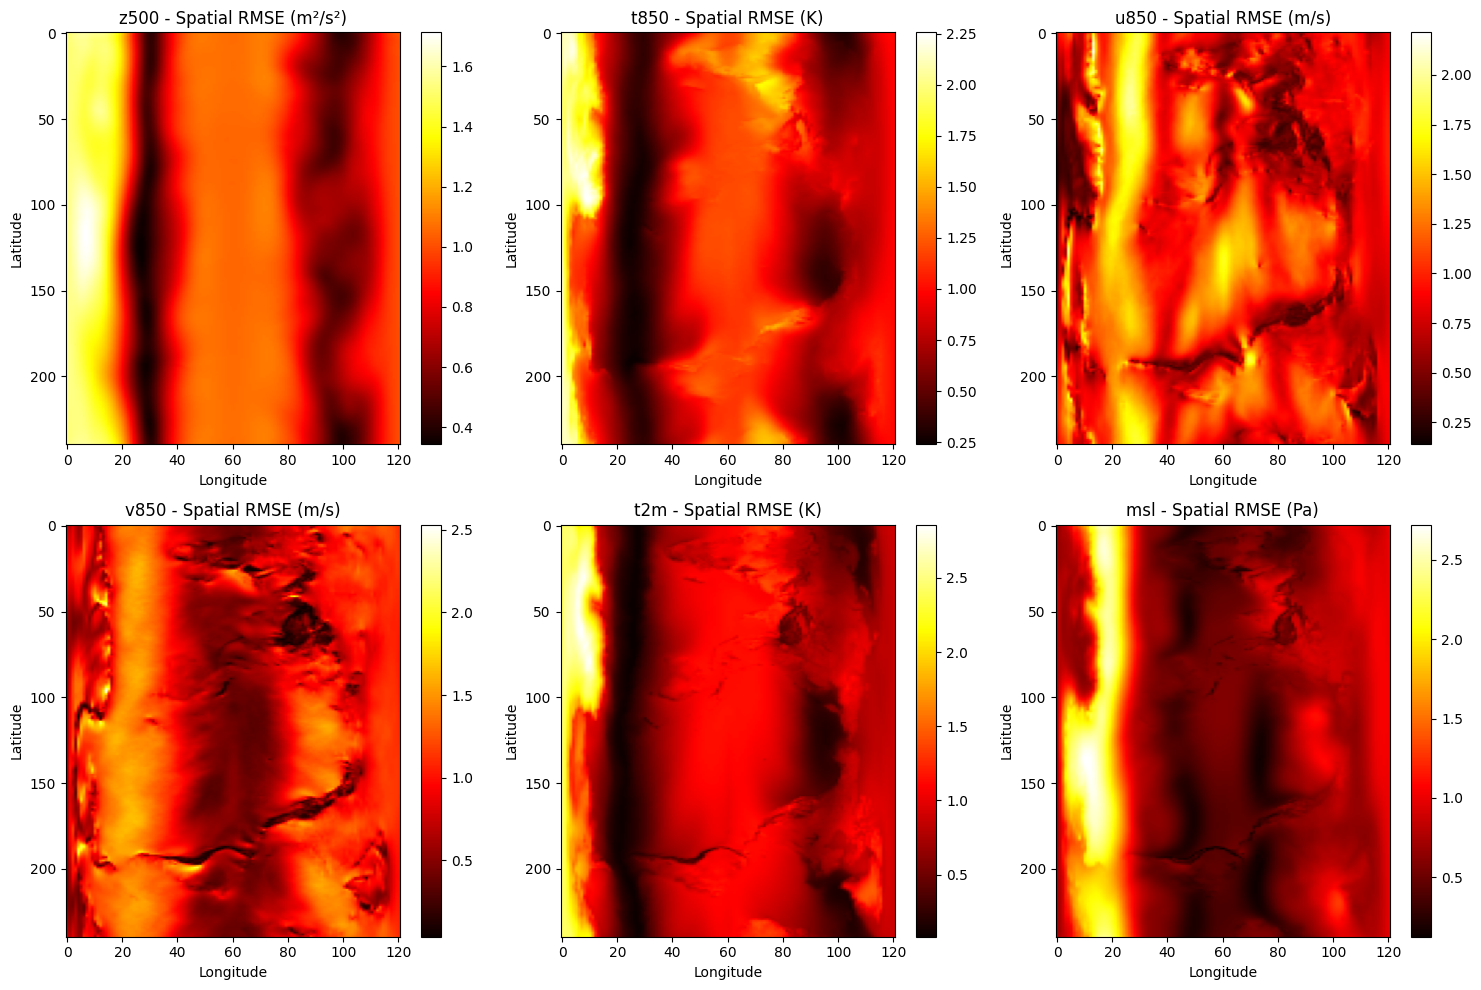

Spatial RMSE saved to spatial_rmse.png


In [9]:
# Compute spatial RMSE (per location, averaged over samples)
errors = predictions - test_targets
spatial_mse = np.mean(errors**2, axis=0)  # (C, H, W)
spatial_rmse = np.sqrt(spatial_mse)

# Plot spatial RMSE for each channel
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for c in range(N_CHANNELS):
    ax = axes[c]
    im = ax.imshow(spatial_rmse[c], aspect='auto', cmap='hot')
    ax.set_title(f'{CHANNEL_NAMES[c]} - Spatial RMSE ({CHANNEL_UNITS[c]})')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('spatial_rmse.png', dpi=150)
plt.show()

print('Spatial RMSE saved to spatial_rmse.png')

## 6. Temporal Error Analysis

Check if error varies with sample index (potential seasonal patterns).

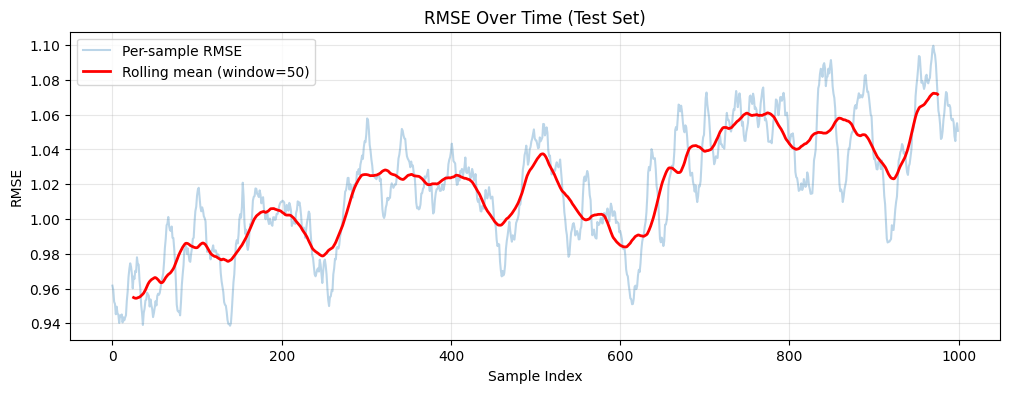

Temporal RMSE saved to temporal_rmse.png


In [10]:
# Compute RMSE per sample
sample_mse = np.mean(errors**2, axis=(1, 2, 3))  # (samples,)
sample_rmse = np.sqrt(sample_mse)

# Rolling average for smoothing
window = 50
rolling_rmse = np.convolve(sample_rmse, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 4))
plt.plot(sample_rmse, alpha=0.3, label='Per-sample RMSE')
plt.plot(np.arange(window//2, len(sample_rmse) - window//2 + 1), rolling_rmse, 
         'r-', linewidth=2, label=f'Rolling mean (window={window})')
plt.xlabel('Sample Index')
plt.ylabel('RMSE')
plt.title('RMSE Over Time (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('temporal_rmse.png', dpi=150)
plt.show()

print('Temporal RMSE saved to temporal_rmse.png')

## 7. Sample Predictions Visualization

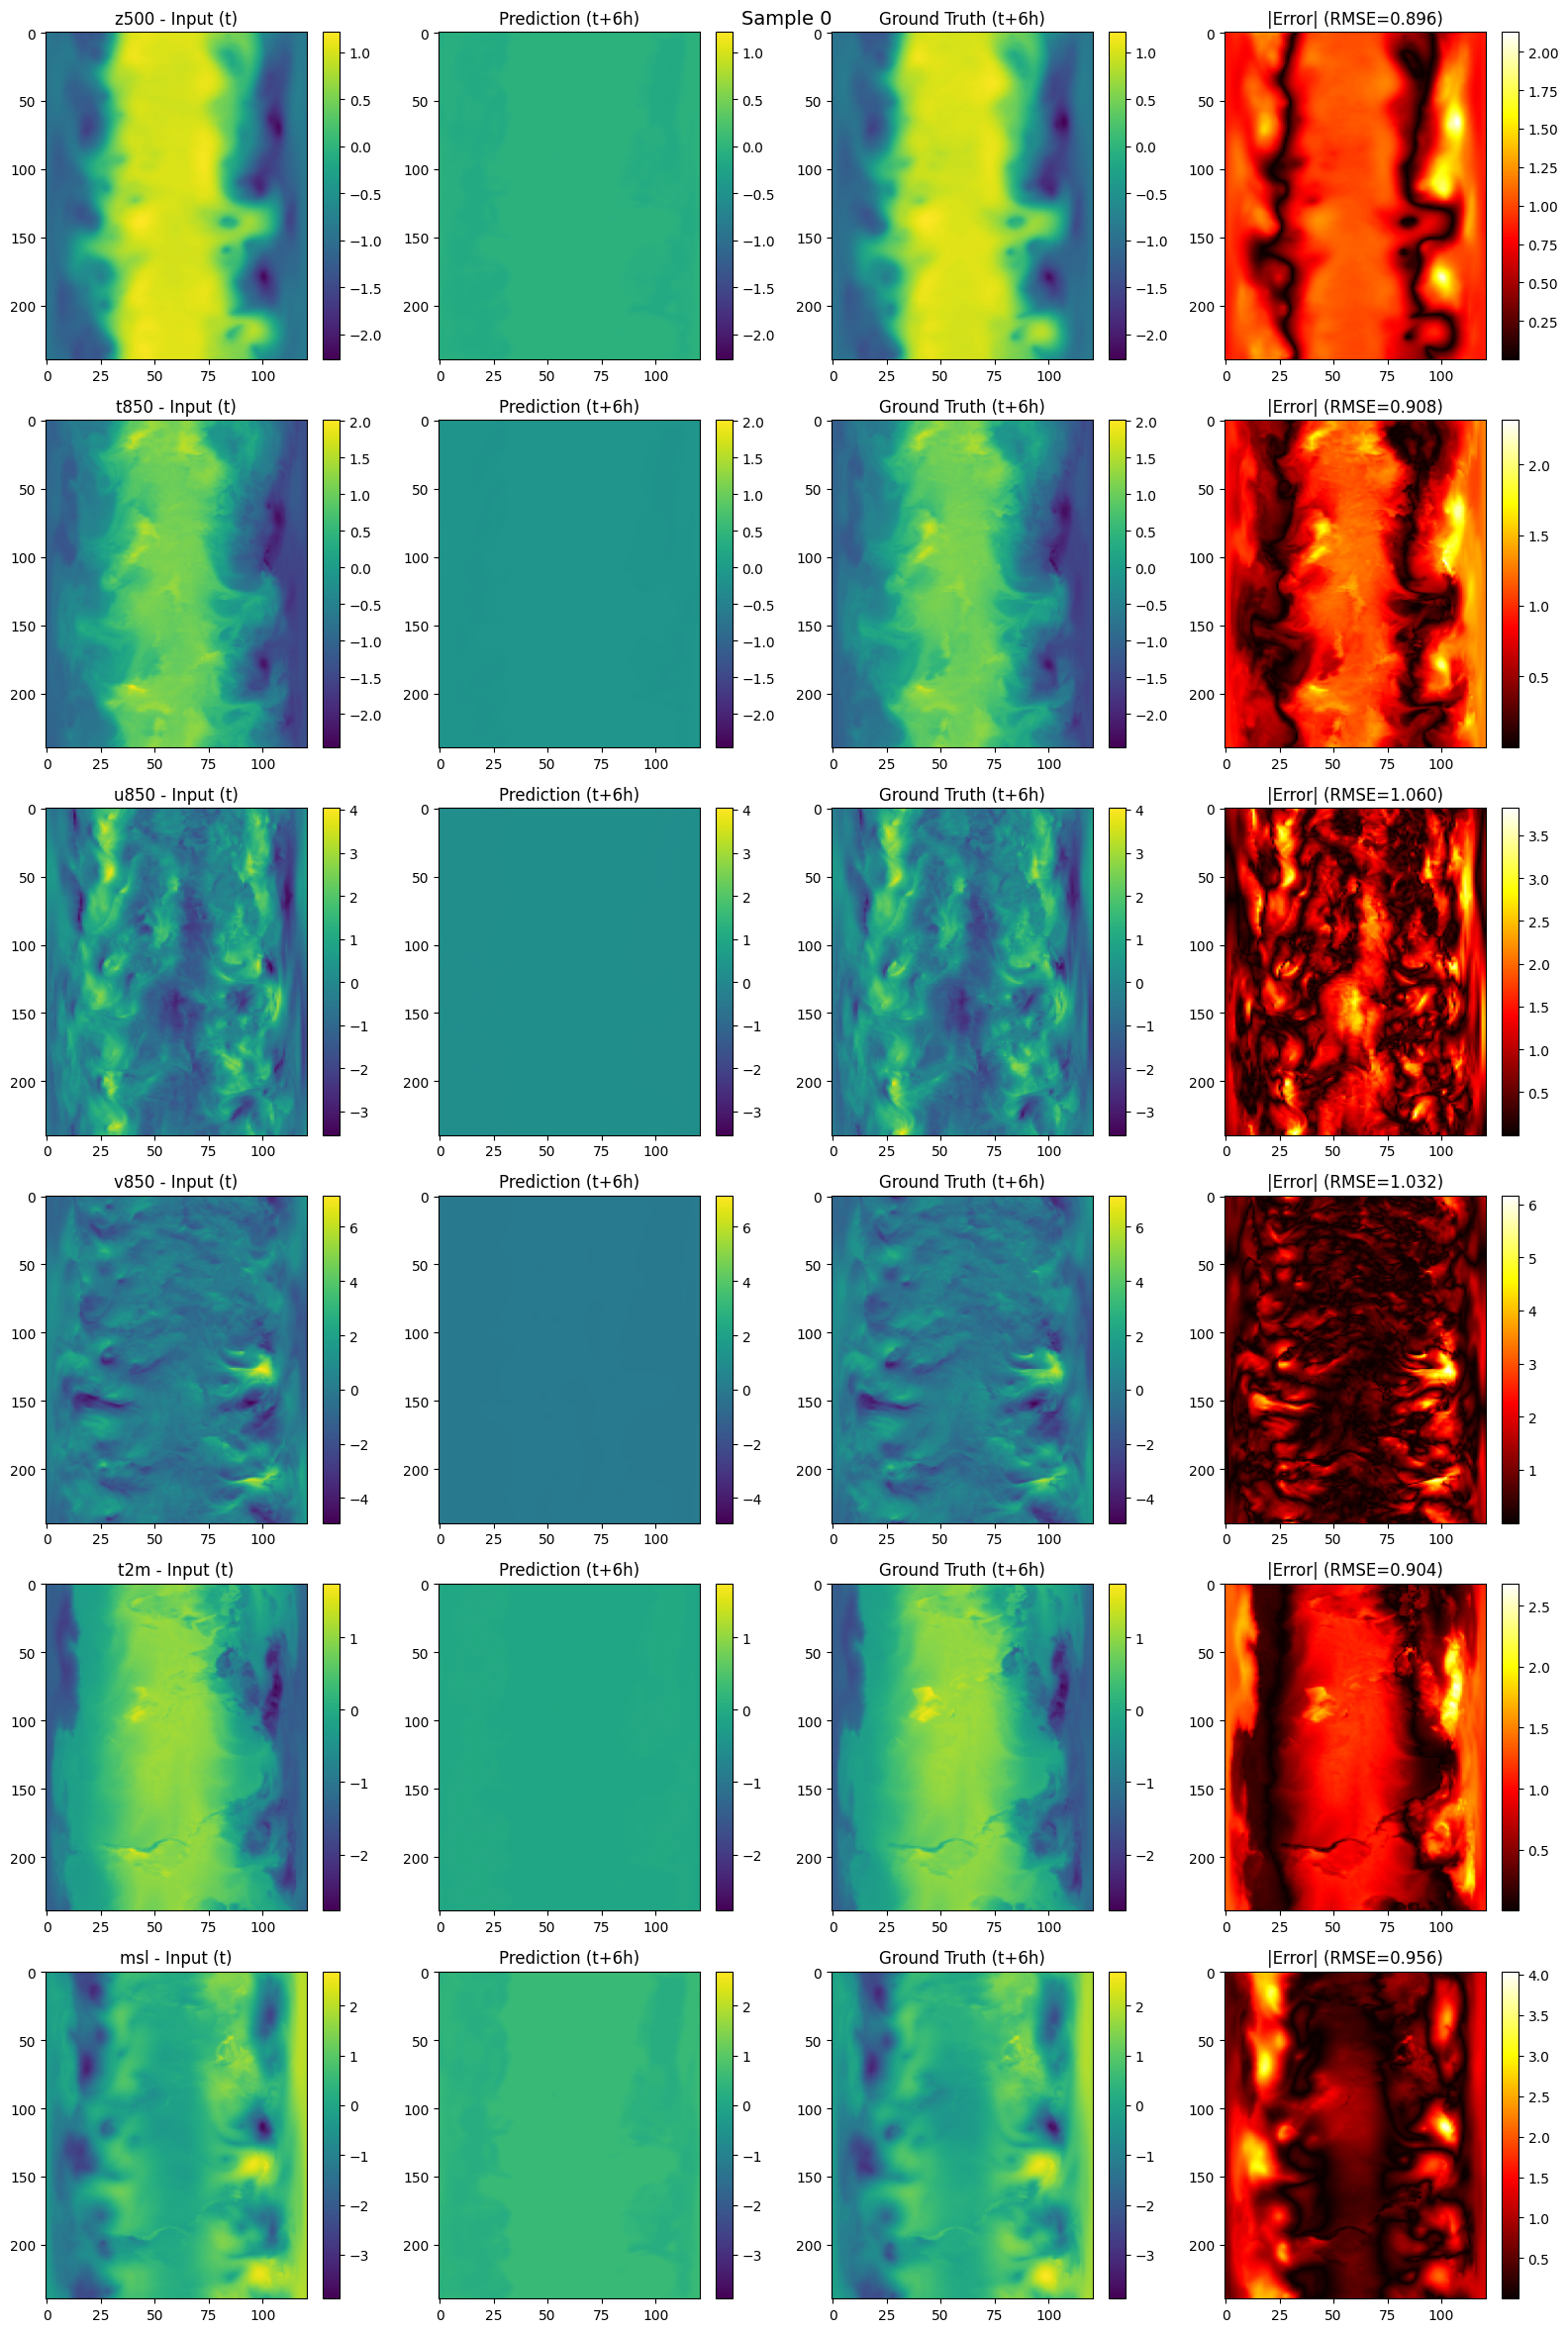

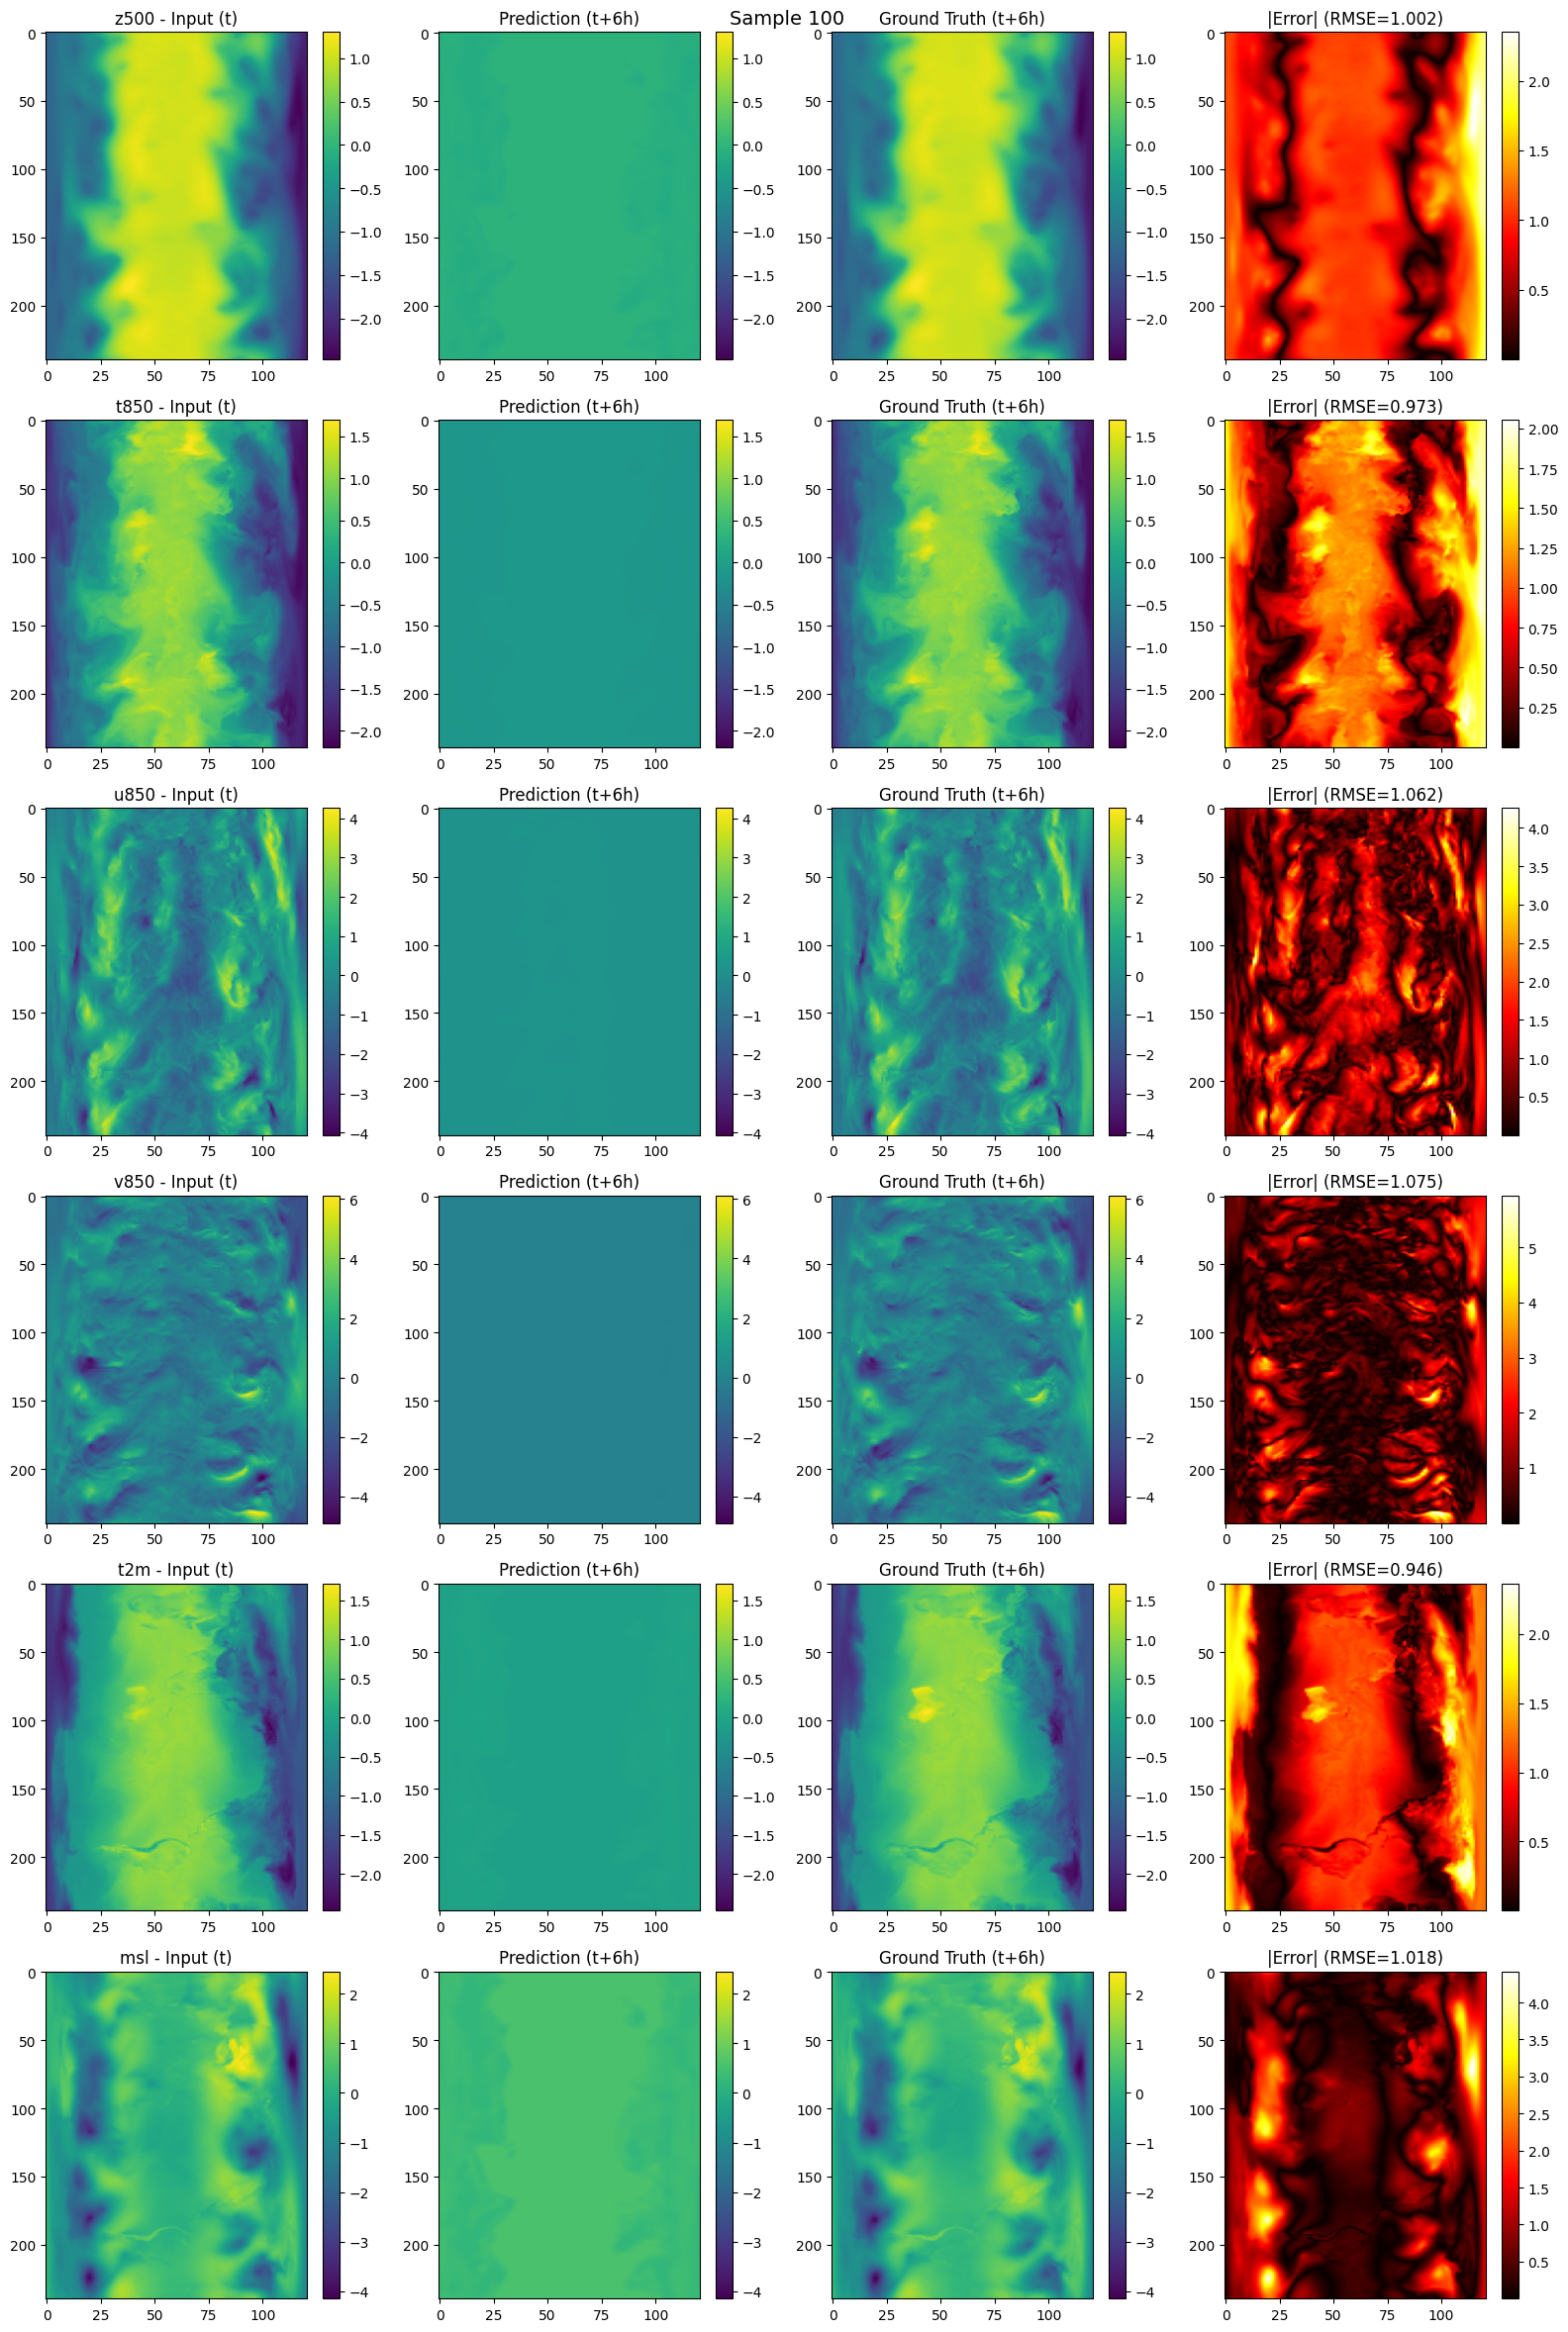

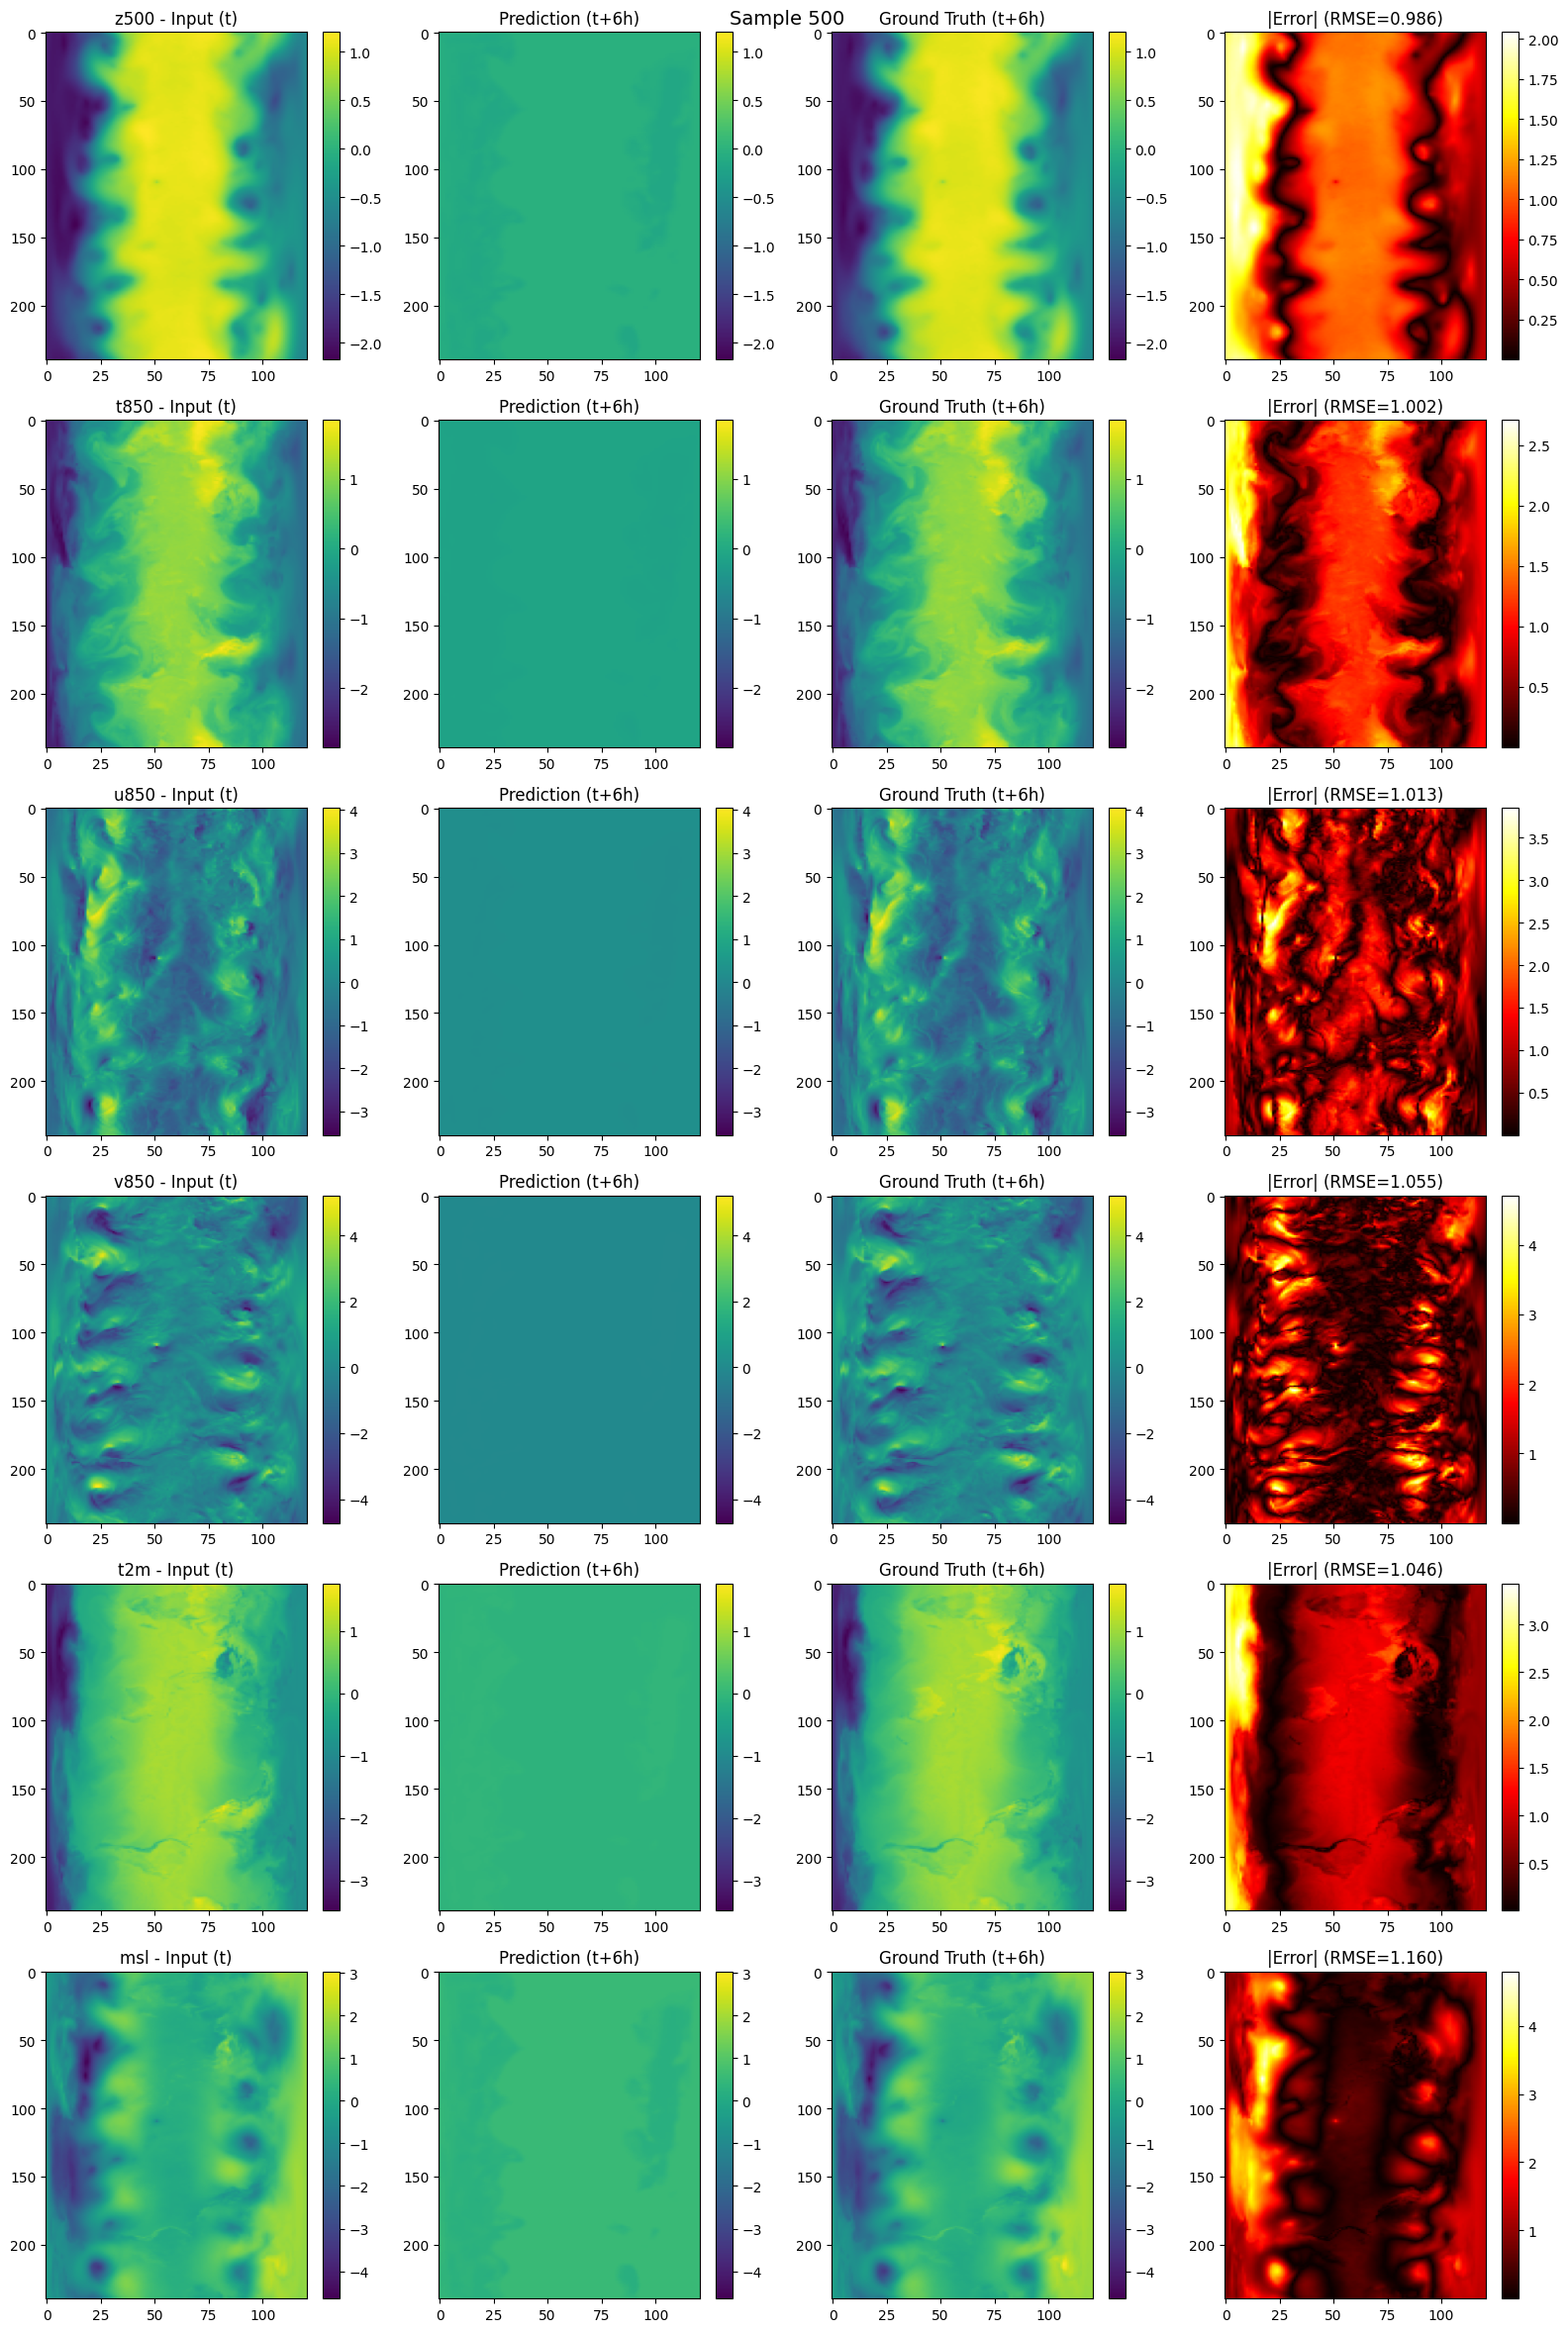

In [11]:
def plot_sample(sample_idx, predictions, targets, inputs):
    """Visualize a single sample: input, prediction, target, error."""
    fig, axes = plt.subplots(N_CHANNELS, 4, figsize=(16, 24))
    
    for c in range(N_CHANNELS):
        inp = inputs[sample_idx, c]
        pred = predictions[sample_idx, c]
        tgt = targets[sample_idx, c]
        err = np.abs(pred - tgt)
        
        vmin = min(inp.min(), pred.min(), tgt.min())
        vmax = max(inp.max(), pred.max(), tgt.max())
        
        # Input (t)
        im0 = axes[c, 0].imshow(inp, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
        axes[c, 0].set_title(f'{CHANNEL_NAMES[c]} - Input (t)')
        plt.colorbar(im0, ax=axes[c, 0])
        
        # Prediction (t+6h)
        im1 = axes[c, 1].imshow(pred, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
        axes[c, 1].set_title('Prediction (t+6h)')
        plt.colorbar(im1, ax=axes[c, 1])
        
        # Target (t+6h)
        im2 = axes[c, 2].imshow(tgt, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
        axes[c, 2].set_title('Ground Truth (t+6h)')
        plt.colorbar(im2, ax=axes[c, 2])
        
        # Error
        im3 = axes[c, 3].imshow(err, aspect='auto', cmap='hot')
        axes[c, 3].set_title(f'|Error| (RMSE={np.sqrt(np.mean(err**2)):.3f})')
        plt.colorbar(im3, ax=axes[c, 3])
    
    plt.suptitle(f'Sample {sample_idx}', fontsize=14)
    plt.tight_layout()
    return fig

# Plot a few samples
for idx in [0, 100, 500]:
    if idx < len(predictions):
        fig = plot_sample(idx, predictions, test_targets, test_inputs)
        plt.savefig(f'sample_{idx:04d}_analysis.png', dpi=100)
        plt.show()

## 8. Summary Report

In [12]:
print('='*70)
print('CLIMATE U-NET EVALUATION SUMMARY')
print('='*70)
print(f'\nModel: {WEIGHTS_DIR.name}')
print(f'Test samples: {len(predictions)}')
print(f'Prediction horizon: 6 hours')

print('\n' + '-'*70)
print('RMSE (lower is better)')
print('-'*70)
print(f'{"Variable":8s} {"RMSE":>10s} {"Unit":>10s}')
for name, unit, rmse in zip(CHANNEL_NAMES, CHANNEL_UNITS, rmse_per_channel):
    print(f'{name:8s} {rmse:10.4f} {unit:>10s}')
print(f'{"Overall":8s} {rmse_overall:10.4f}')

print('\n' + '-'*70)
print('ACC - Anomaly Correlation (>0.6 = useful)')
print('-'*70)
for name, acc in zip(CHANNEL_NAMES, acc_per_channel):
    status = '✓ USEFUL' if acc > 0.6 else '✗ LIMITED'
    print(f'{name:8s} {acc:10.4f}  {status}')
print(f'{"Mean":8s} {acc_per_channel.mean():10.4f}')

print('\n' + '-'*70)
print('Improvement over Persistence Baseline')
print('-'*70)
for name, m_rmse, p_rmse in zip(CHANNEL_NAMES, rmse_model, rmse_persistence):
    improvement = (p_rmse - m_rmse) / p_rmse * 100
    status = '✓' if improvement > 0 else '✗'
    print(f'{name:8s} {improvement:+10.1f}%  {status}')

print('\n' + '='*70)
print('CONCLUSIONS')
print('='*70)

# Automated conclusions
if acc_per_channel.mean() > 0.6:
    print('✓ Model shows USEFUL skill (mean ACC > 0.6)')
elif acc_per_channel.mean() > 0.3:
    print('△ Model shows SOME skill (mean ACC 0.3-0.6)')
else:
    print('✗ Model shows LIMITED skill (mean ACC < 0.3)')

improvement = (overall_persistence - overall_model) / overall_persistence * 100
if improvement > 0:
    print(f'✓ Model beats persistence by {improvement:.1f}%')
else:
    print(f'✗ Model underperforms persistence by {-improvement:.1f}%')

print('\n' + '='*70)

CLIMATE U-NET EVALUATION SUMMARY

Model: epoch_0021
Test samples: 1000
Prediction horizon: 6 hours

----------------------------------------------------------------------
RMSE (lower is better)
----------------------------------------------------------------------
Variable       RMSE       Unit
z500         0.9886      m²/s²
t850         1.0211          K
u850         1.0343        m/s
v850         1.0004        m/s
t2m          1.0370          K
msl          1.0218         Pa
Overall      1.0173

----------------------------------------------------------------------
ACC - Anomaly Correlation (>0.6 = useful)
----------------------------------------------------------------------
z500         0.0152  ✗ LIMITED
t850         0.0030  ✗ LIMITED
u850        -0.0021  ✗ LIMITED
v850        -0.0004  ✗ LIMITED
t2m         -0.0037  ✗ LIMITED
msl          0.0508  ✗ LIMITED
Mean         0.0105

----------------------------------------------------------------------
Improvement over Persistence Baseli

## 9. Next Steps

### To improve the model:
1. **Train longer** - Current model only trained 15 epochs
2. **Learning rate scheduling** - Reduce LR when loss plateaus
3. **Data augmentation** - Horizontal flips, small rotations
4. **Larger model** - More channels in encoder/decoder
5. **Residual connections** - Predict change rather than absolute values

### For proper benchmarking:
1. **Use actual climatology** - Not target mean
2. **Latitude weighting** - Weight by cos(latitude)
3. **Multiple lead times** - 6h, 12h, 24h, 3d, 5d
4. **Ensemble methods** - Probabilistic predictions
5. **Physical consistency** - Conservation laws, spectral analysis